In [1]:
%load_ext autotime

time: 214 µs (started: 2022-07-05 15:15:14 +08:00)


In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

time: 775 ms (started: 2022-07-05 15:15:14 +08:00)


In [3]:
from matplotlib.backends.backend_pdf import PdfPages

time: 58.9 ms (started: 2022-07-05 15:15:14 +08:00)


In [4]:
pd.set_option('display.max_rows', 200, 'display.max_columns', None)

time: 186 µs (started: 2022-07-05 15:15:14 +08:00)


In [5]:
all_rows = pd.option_context("display.max_rows", None)

time: 255 µs (started: 2022-07-05 15:15:14 +08:00)


In [6]:
months = pd.Series({m: i for i, m in enumerate("FGHJKMNQUVXZ")})

time: 710 µs (started: 2022-07-05 15:15:15 +08:00)


In [7]:
dailies = pd.read_parquet("csi_data.parquet").rename(columns={"symbol": "contract"})
dailies.close *= dailies.mult
dailies.volume /= dailies.mult
dailies.open_interest /= dailies.mult

time: 7.11 s (started: 2022-07-05 15:15:15 +08:00)


In [8]:
prev_close = dailies.sort_values("date").groupby(["contract", "expiry"]).close.shift()
dailies["d_close"] = dailies.close - prev_close

time: 15.2 s (started: 2022-07-05 15:15:22 +08:00)


In [9]:
dailies["expiry_int"] = (
    dailies["expiry"].str.slice(0, 4).astype(int) * 12 + 
    dailies["expiry"].str.slice(4, 5).map(months)
)

time: 17.2 s (started: 2022-07-05 15:15:37 +08:00)


In [10]:
dailies["mod_month"] = dailies.eval(
    "expiry_int - (date.dt.year + (expiry_int.mod(12) < date.dt.month.sub(1))) * 12"
)

time: 2.25 s (started: 2022-07-05 15:15:54 +08:00)


In [11]:
dailies[["expiry_int", "mod_month"]] = dailies[["expiry_int", "mod_month"]].astype("Int64")

time: 8.37 s (started: 2022-07-05 15:15:56 +08:00)


In [12]:
dailies = dailies.query("mod_month.between(0, 11)").copy()

time: 3.91 s (started: 2022-07-05 15:16:05 +08:00)


In [13]:
dailies["mod_month"] = pd.Categorical.from_codes(dailies["mod_month"], months.index)

time: 41.6 ms (started: 2022-07-05 15:16:09 +08:00)


In [14]:
metadata = (
    pd.read_csv("contracts.csv")
    .dropna(subset=["Exch Symbol", "Currency", "Name", "Point Value", 
                    "Symbol", 'Futures Category'])
    .loc[lambda df: ~df.Symbol.isin(["TW1", "TW2"])]
    .set_index("Symbol")
)
metadata.loc[lambda df: df["Futures Category"].isin([
    'Indexes-Asian', 'Indexes-Australian',
    'Indexes-Canadian', 'Indexes-European',
    'Indexes-Global', 'Indexes-Indian Stocks',
    'Indexes-Mexican', 'Indexes-S. African', 'Indexes-S. American',
    'Indexes-U.S.',
]), 'Futures Category'] = "Equity Index"
metadata.loc[
    lambda df: df["Futures Category"].isin([
        'Govt Notes', 'Govt Bonds', 'Govt Rates', 'Interest Rates', 'Indexes-U.S. Bonds',
    ]), 'Futures Category'] = "Fixed Income"

time: 23.2 ms (started: 2022-07-05 15:16:09 +08:00)


In [15]:
names = metadata["Name"].str.lower()
point_values = metadata["Point Value"].str.lower()

time: 1.37 ms (started: 2022-07-05 15:16:09 +08:00)


In [45]:
contract_mask = (
    metadata.Currency.isin(["USD", "EUR"])
    &
    metadata["Close Field Type"].eq("Settlement")
    &
    ~point_values.str.contains("contract")
    &
    ~point_values.str.contains("mwh")    
    &
    ~names.index.isin(["TF", "ER2", "SP2", "ZI", "ZN", "TU2", "LC1"])
    &
    (
        names.str.contains("combined session")
        |
        ~names.str.contains("session")
    )
    &
    ~names.str.contains("divided by 10")
)

time: 15.2 ms (started: 2022-07-05 15:24:53 +08:00)


In [46]:
multiplier = (
    point_values
    .loc[
        lambda df: (
            df.str.match("(usd|eur|\$|\d)")
            |
            df.str.contains("us dollar")
        )
    ]
    .str.extract("(\d+(?:[.]\d*)?|[.]\d+)", expand=False).astype(float)
    .rename("multiplier")
)
metadata["multiplier"] = multiplier

time: 4.98 ms (started: 2022-07-05 15:24:53 +08:00)


In [47]:
dailies = dailies.loc[lambda df: df.contract.map(contract_mask).fillna(False)]

time: 541 ms (started: 2022-07-05 15:24:53 +08:00)


In [48]:
contract_volumes = (
    dailies
    .assign(decade=lambda df: df.eval("date.dt.year.floordiv(10).mul(10)"))
    .assign(adr=lambda df: df.eval("high - low"))
    .groupby(["contract", "decade"])
    .agg({"volume": "mean", "adr": "mean"})
    .reset_index()
)

time: 1.23 s (started: 2022-07-05 15:24:54 +08:00)


In [49]:
contract_volumes["multiplier"] = contract_volumes.contract.map(metadata.multiplier)
contract_volumes["currency"] = contract_volumes.contract.map(metadata.Currency)
contract_volumes["category"] = contract_volumes.contract.map(metadata['Futures Category'])
contract_volumes["exchange"] = contract_volumes.contract.map(metadata.Exchange)
contract_volumes["exch_symbol"] = contract_volumes.contract.map(metadata['Exch Symbol'])
contract_volumes["name"] = contract_volumes.contract.map(metadata['Name'])
contract_volumes["dollar_vol"] = contract_volumes.eval("adr * multiplier * volume")
contract_volumes["cat_rank"] = (
    contract_volumes.groupby(["category", "decade"])
    .dollar_vol.rank(ascending=False)
    .fillna(0).astype(int)
)
contract_volumes["start_year"] = contract_volumes.contract.map(
    dailies.groupby("contract").date.min().dt.year.astype("Int64")
)

time: 209 ms (started: 2022-07-05 15:24:55 +08:00)


In [82]:
shortlist = (
    contract_volumes    
    .query("category != 'Equity Index'")
    .query("cat_rank <= 7 & start_year < 2000 & decade == 2010")
    .query("dollar_vol.rank(ascending=False) <= 50")
    .sort_values("dollar_vol", ascending=False)
    [["dollar_vol", "currency", "contract", "exchange", "exch_symbol",
      "category", "cat_rank", "name", "start_year"]]
    .reset_index(drop=True)
)
with all_rows:
    display(
        shortlist
        .style
        .format(subset=["dollar_vol"], formatter="{:.1e}")
        .set_properties(subset=["name"], **{'white-space': 'pre-wrap'})
    )

,dollar_vol,currency,contract,exchange,exch_symbol,category,cat_rank,name,start_year
0,3.1e+08,USD,US,CBT,US,Fixed Income,1,U.S. T-Bond (combined)-CBT,1977
1,2.0e+08,USD,TY,CBT,TYF,Fixed Income,2,10-Year U.S. T-Note (combined)-CBT,1982
2,1.2e+08,USD,CL2,NYMEX,CL,Energy,1,Crude Oil (combined)-NYMEX,1983
3,1.2e+08,EUR,EBL,EUREX,FGBL,Fixed Income,3,Euro German Bund-EUREX,1990
4,1.2e+08,USD,FV,CBT,FV,Fixed Income,4,5-Year U.S. T-Note (combined)-CBT,1988
5,9.6e+07,USD,LCO,ICE-EU,B,Energy,2,Brent Crude (Combined)-(IPE),1988
6,7.2e+07,USD,GC2,COMEX,GC,Metals,1,Gold (combined)-COMEX,1976
7,6.6e+07,USD,CU,CME,Y2,FOREX,1,Euro (combined)-CME,1976
8,4.5e+07,USD,S2,CBT,S,Grains & Oilseeds,1,Soybeans (combined)-CBT,1976
9,4.4e+07,USD,C2,CBT,C,Grains & Oilseeds,2,Corn (combined)-CBT,1976


time: 30.5 ms (started: 2022-07-05 17:56:37 +08:00)


In [83]:
top_ratio = (
    dailies
    .query("date > '2008'")
    .sort_values("volume")
    .groupby(["contract", "date"]).last()
    .groupby(["contract", "mod_month"]).volume.count()
)
top_ratio /= top_ratio.groupby("contract").transform("max")

time: 18 s (started: 2022-07-05 17:56:37 +08:00)


In [84]:
with PdfPages('expiry_volumes.pdf') as pdf:
    for contract_rank in tqdm(shortlist.index):

        title = "{contract_rank} - {contract} / {exch_symbol}({exchange}) / {name}".format(
            contract_rank=contract_rank, **shortlist.loc[contract_rank].to_dict()
        )

        plt.figure(dpi=100)

        ax = (
            top_ratio
            .loc[shortlist.contract[contract_rank]]
            .plot.bar(figsize=(8, 5), title=title)
        )
        
        ax.axhline(y=1/12, color="red")
        
        pdf.savefig()
        plt.close()        

  0%|          | 0/43 [00:00<?, ?it/s]

time: 1.94 s (started: 2022-07-05 17:56:55 +08:00)


In [85]:
active_months = top_ratio[top_ratio > 1/12].reset_index().drop("volume", axis=1)
dailies = dailies.merge(active_months)

time: 646 ms (started: 2022-07-05 17:56:57 +08:00)


In [86]:
volumes = dailies.set_index(["contract", "date", "expiry"]).volume.loc[lambda xs: xs > 0]
volumes /= volumes.groupby(["contract", "date"]).transform("sum")
volumes = volumes.sort_index().rename("volume_fraction")
volumes = volumes.groupby(["contract", "expiry"]).shift()

time: 1.99 s (started: 2022-07-05 17:56:58 +08:00)


In [87]:
front = (
    volumes
    .loc[lambda df: df.groupby(["contract", "expiry"]).cummax().gt(1/3)]
    .reset_index()
    .sort_values("expiry")
    .groupby(["contract", "date"])
    .first().set_index("expiry", append=True)
    .join(dailies.set_index(["contract", "date", "expiry"]))
    .reset_index("expiry")
)

time: 4.61 s (started: 2022-07-05 17:57:00 +08:00)


In [88]:
front["vol"] = (
    front
    .d_close.abs()
    .groupby("contract").rolling(180).mean()
    .reset_index(level=0, drop=True)
    .groupby("contract").shift()
)

time: 180 ms (started: 2022-07-05 17:57:04 +08:00)


In [89]:
dollar_vol2 = front["vol"].groupby("contract").last().mul(metadata.multiplier).dropna()

time: 21.7 ms (started: 2022-07-05 17:57:04 +08:00)


In [90]:
shortlist_sizing = (
    shortlist
    .assign(dollar_vol2=lambda df: df.contract.map(dollar_vol2))
    .assign(dollar_tick=lambda df: df.contract.map(metadata.eval("MinTick * multiplier")))
    .assign(vol_ticks=lambda df: df.eval("dollar_vol2 / dollar_tick"))
    [["dollar_vol2", "dollar_tick", "vol_ticks", "currency", "contract", "exchange", "exch_symbol",
      "category", "cat_rank", "name", "start_year"]]
    .sort_values("dollar_vol2", ascending=False)
)
with all_rows:
    display(
        shortlist_sizing
        .style
        .format(subset=["dollar_vol2"], formatter="{:,.0f}")
        .format(subset=["vol_ticks", "dollar_tick"], formatter="{:,.1f}")
        .set_properties(subset=["name"], **{'white-space': 'pre-wrap'})
    )

,dollar_vol2,dollar_tick,vol_ticks,currency,contract,exchange,exch_symbol,category,cat_rank,name,start_year
35,"5,259",50.0,105.2,USD,PA2,NYMEX,PA,Metals,5,Palladium (combined)-NYMEX,1977
17,"3,529",4.2,840.2,USD,HO2,NYMEX,HO,Energy,6,NY Harbor ULSD (combined)-NYMEX,1978
0,"2,826",15.6,180.9,USD,US,CBT,US,Fixed Income,1,U.S. T-Bond (combined)-CBT,1977
16,"2,687",4.2,639.7,USD,RB2,NYMEX,RB,Energy,5,Gasoline-Reformulated Blendstock(Combined)-NYMEX,1984
11,"2,413",10.0,241.3,USD,NG2,NYMEX,NG,Energy,3,Henry Hub Natural Gas (combined)-NYMEX,1990
2,"2,184",10.0,218.4,USD,CL2,NYMEX,CL,Energy,1,Crude Oil (combined)-NYMEX,1983
5,"2,110",10.0,210.9,USD,LCO,ICE-EU,B,Energy,2,Brent Crude (Combined)-(IPE),1988
10,"1,613",5.0,322.7,USD,SI2,COMEX,SI,Metals,2,Silver (combined)-COMEX,1976
12,"1,596",25.0,63.8,USD,LGO,ICE-EU,G,Energy,4,Low Sulphur Gasoil (combined),1981
25,"1,444",18.8,77.0,USD,KC2,ICE-US,KC,Food & Fiber,2,Coffee (combined),1976


time: 17.5 ms (started: 2022-07-05 17:57:04 +08:00)


In [91]:
with PdfPages('prices.pdf') as pdf:
    for contract in tqdm(shortlist.itertuples(), total=len(shortlist)):
        title = (f"{contract.Index} - {contract.contract} / "
                 f"{contract.exch_symbol}({contract.exchange}) / {contract.name}")
        plt.figure(dpi=100)

        (
            front.loc[contract.contract]
            .eval("d_close / vol").cumsum()
            .plot(figsize=(8, 5), title=title)
        )
        
        pdf.savefig()
        plt.close()        

  0%|          | 0/43 [00:00<?, ?it/s]

time: 2.92 s (started: 2022-07-05 17:57:04 +08:00)


In [99]:
signals = []
for ndays in [90, 120, 180]:
    signals.append(
        front
        .eval("d_close / vol")
        .groupby("contract").cumsum()
        .pipe(lambda xs: (
            xs.groupby("contract").rolling(ndays).mean().reset_index(level=0, drop=True)
            .lt(xs)
        ))
        .groupby("contract").shift(fill_value=False)
        .pipe(lambda xs: xs * 2 - 1)
        .groupby("contract").rolling(30).mean().reset_index(level=0, drop=True)
    )
signal = pd.concat(signals, axis=1).mean(axis=1)

time: 1.35 s (started: 2022-07-05 22:27:50 +08:00)


In [100]:
start_year = "1980"

rets = front.eval("d_close / vol * @signal")
pnl = rets.loc[shortlist.contract].groupby("date").sum()[start_year:]
bnh_rets = front.eval("d_close / vol")

time: 230 ms (started: 2022-07-05 22:27:52 +08:00)


In [101]:
def plot_dd(c_pl, title):
    xlim=(c_pl.index[0], c_pl.index[-1])
    c_pl.plot(lw=1, color="black", title=title, xlim=xlim)
    plt.ylabel("Cumulative vol-normalized points")
    plt.fill_between(c_pl.index, c_pl, c_pl.cummax(), facecolor='red', alpha=0.5);
    

time: 346 µs (started: 2022-07-05 22:27:52 +08:00)


In [102]:
with PdfPages('returns.pdf') as pdf:
    c_pl = pnl.cumsum()
    plt.figure(figsize=(8, 5), dpi=100)
    plot_dd(c_pl, title="Trend")
    
    ax = (
        front.loc[shortlist.contract]
        .groupby("date").expiry.count()
        .cummax()
        .plot(secondary_y=True)
    )
    ax.set_ylabel("Contract Count", rotation=-90, labelpad=20)
    ax.set_ylim(0, None)

    pdf.savefig()
    plt.close("all")
    
    c_bnh = (
        bnh_rets.loc[shortlist.contract]
        .groupby("date").sum()
        [start_year:].cumsum()
    )
    plt.figure(figsize=(8, 5), dpi=100)
    plot_dd(c_bnh, title="Buy and Hold")

    pdf.savefig()
    plt.close("all")
    
    for contract in tqdm(shortlist.itertuples(), total=len(shortlist)):
        title = (f"{contract.Index} - {contract.contract} / "
                 f"{contract.exch_symbol}({contract.exchange}) / {contract.name}")
        
        all_rets = pd.DataFrame({
            "trend": rets.loc[contract.contract],
            "buy and hold": bnh_rets.loc[contract.contract],
        })
        
        plt.figure(dpi=100)
        
        ax = signal.loc[contract.contract].plot(secondary_y=True, color="grey", alpha=0.3)
        ax.set_ylabel("Signal", rotation=-90)
#         ax.set_ylim(-0.2, 1.3)
        
        ax = (
            all_rets.loc[start_year:].cumsum()
            .plot(
                figsize=(8, 5), 
                title=title,
                xlim=(pnl.index[0], pnl.index[-1]),
                ax=ax,
            )
        )
        ax.left_ax.set_ylabel("Cumulative vol-normalized points")
        ax.legend(*ax.left_ax.get_legend_handles_labels(), loc="upper left")
                
        pdf.savefig()
        plt.close("all")

  0%|          | 0/43 [00:00<?, ?it/s]

time: 6.36 s (started: 2022-07-05 22:27:52 +08:00)


In [103]:
decade = (pnl.index.get_level_values("date").year // 5) * 5
by_period = {}
legend = []
for _, pnl0 in pnl.groupby(decade):
    yr0 = pnl0.index.year[0]
    pnl0.index = ((pnl0.index - pd.Timestamp(yr0, 1, 1)) / pd.Timedelta(days=1)).astype(int)
    by_period[yr0] = pnl0
by_period = pd.DataFrame(by_period)

time: 7.15 ms (started: 2022-07-05 22:27:58 +08:00)


<AxesSubplot:xlabel='date'>

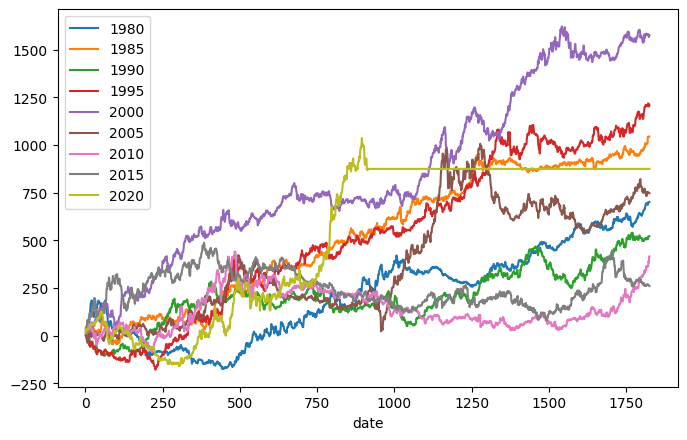

time: 126 ms (started: 2022-07-05 22:27:58 +08:00)


In [104]:
plt.figure(figsize=(8, 5), dpi=100)
by_period.cumsum().fillna(method="ffill").plot(ax=plt.gca())

In [105]:
by_period.apply(lambda xs: xs.mean() / xs.std() * 250**0.5)

1980    0.997034
1985    1.516540
1990    0.721953
1995    1.327710
2000    1.557531
2005    0.662548
2010    0.446559
2015    0.274839
2020    1.404356
dtype: float64

time: 3.96 ms (started: 2022-07-05 22:27:58 +08:00)
